In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

# pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
candidate_sentences = pd.read_excel(r"E:\Farzan\FAST-NUCES\5th Semester\KRR\Project\text.xlsx")
candidate_sentences.shape

(998, 1)

In [3]:
candidate_sentences['Text'].sample(5)

528     Salah is the name of a specific type of praye...
47     Oneness of Allah means that He is the only god...
681    Ramadan is observed by Muslims as a time of sp...
257    Fasting can also help us focus on our relation...
168    Fasting helps you to reconnect with your body ...
Name: Text, dtype: object

In [4]:

doc = nlp("Tauheed is an Arabic word meaning oneness or uniqueness")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Tauheed ... nsubj
is ... ROOT
an ... det
Arabic ... amod
word ... attr
meaning ... acl
oneness ... dobj
or ... cc
uniqueness ... conj


In [5]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [6]:
get_entities("Tauheed is the third pillar of Islam")

['Tauheed', 'third  Islam']

In [7]:
entity_pairs = []

for i in tqdm(candidate_sentences["Text"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 998/998 [00:09<00:00, 105.91it/s]


In [8]:
entity_pairs[10:20]

[['what', 'other  religions'],
 ['Allah', 'worthy  worship'],
 ['He', 'partner'],
 ['only  who', 'devotion'],
 ['truly  one', 'first  Tauheed'],
 ['concept', 'hand  angels'],
 ['things', 'important  humanity'],
 ['Angels', 'us'],
 ['prophets', 'how  laws'],
 ['Understanding', 'meaningful  Muslim']]

In [9]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [10]:
get_relation("Zakat is an act of charity")

'is'

In [11]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['Text'])]

100%|██████████| 998/998 [00:10<00:00, 97.64it/s] 


In [12]:
pd.Series(relations).value_counts()[:50]

is              363
means            46
believe          15
considered       15
are              15
's               15
consists of      14
takes            12
called           11
involves         10
encouraged       10
known as          9
performed         9
try               8
given in          7
refers to         7
helps             7
given             7
states            6
depends on        6
said              6
has               6
includes          5
used              5
help              5
make              4
word              4
done              4
include           4
lasts for         4
testify           4
pray              4
comes from        4
perform           4
choose            3
's important      3
give              3
born in           3
says              3
lasts             3
recite            3
used as           3
say               3
required          3
seek              3
derived from      3
ask               3
pray for          3
are many          3
eat               3


In [13]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [14]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

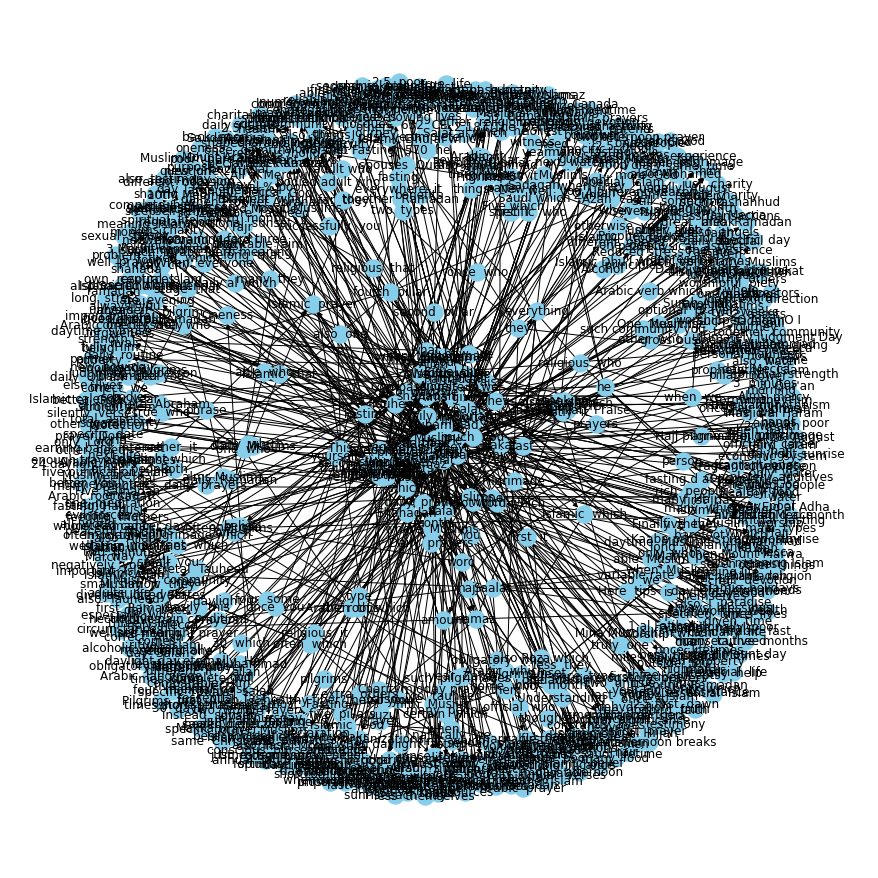

In [15]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()